<a href="https://colab.research.google.com/github/Medhansh404/Learning_ML/blob/main/AIA_Cohort_Assignment_4_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [0.2] - CNNs & ResNets

Colab: [exercises](https://colab.research.google.com/drive/1sZpsnjN7gI4EucRcD0mCafN5Vg1DPOnm) | [solutions](https://colab.research.google.com/drive/1LDv8fB47OPKPp4C83CO_gTzaUE2bR-Ve)

ARENA 3.0 [Streamlit page](https://arena3-chapter0-fundamentals.streamlit.app/[0.2]_CNNs_&_ResNets)

Please send any problems / bugs on the `#errata` channel in the [Slack group](https://join.slack.com/t/arena-la82367/shared_invite/zt-1uvoagohe-JUv9xB7Vr143pdx1UBPrzQ), and ask any questions on the dedicated channels for this chapter of material.

To view solutions for the exercises, see the Colab solutions page or the Streamlit page.


<img src="https://raw.githubusercontent.com/callummcdougall/Fundamentals/main/images/cnn.png" width="350">


# Introduction



This section is designed to get you familiar with basic neural networks: how they are structured, the basic operations like linear layers and convolutions which go into making them, and why they work as well as they do. You'll start by making very simple neural networks, and by the end of today you'll build up to assembling ResNet34, a comparatively much more complicated architecture.

## Content & Learning Objectives


### 1️⃣ Making your own modules

In the first set of exercises, we'll cover the general structure of modules in PyTorch. You'll also implement your own basic modules, including for ReLU and Linear layers. You'll finish by assembling a very simple neural network.

> ##### Learning objectives
>
> - Learn how to create your own modules in PyTorch, by inheriting from `nn.Module`
> - Assemble the pieces together to create a simple fully-connected network, to classify MNIST digits

### 2️⃣ Training Neural Networks

Here, you'll learn how to write a training loop in PyTorch. We'll keep it simple for today (and later on we'll experiment with more modular and extensible designs).

> ##### Learning objectives
>
> - Understand how to work with transforms, datasets and dataloaders
> - Understand the basic structure of a training loop
> - Learn how to write your own validation loop

### 3️⃣ Convolutions

In this section, you'll read about convolutions, and implement them as an `nn.Module` (not from scratch; we leave that to the bonus exercises). You'll also learn about maxpooling, and implement that as well.

> ##### Learning Objectives
>
> * Learn how convolutions work, and why they are useful for vision models
> * Implement your own convolutions, and maxpooling layers

### 4️⃣ ResNets

Here, you'll combine all the pieces you've learned so far to assemble ResNet34, a much more complex architecture used for image classification.

> ##### Learning Objectives
>
> * Learn about skip connections, and how they help overcome the degradation problem
> * Learn about batch normalization, and why it is used in training
> * Assemble your own ResNet, and load in weights from PyTorch's ResNet implementation

### 5️⃣ Bonus - Convolutions From Scratch

This section takes you through the low-level details of how to actually implement convolutions. It's not necessary to understand this section to complete the exercises, but it's a good way to get a deeper understanding of how convolutions work.

> ##### Learning objectives
>
> * Understand how array strides work, and why they're important for efficient linear operations
> * Learn how to use `as_strided` to perform simple linear operations like trace and matrix multiplication
> * Implement your own convolutions and maxpooling functions using stride-based methods

### 6️⃣ Bonus - Feature Extraction

In this section, you'll learn how to repurpose your ResNet to perform a different task than it was designed for, using feature extraction.

> ##### Learning Objectives
>
> * Understand the difference between feature extraction and finetuning
> * Perform feature extraction on a pre-trained ResNet

## Setup (don't read, just run!)


In [4]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install packages
    %pip install einops
    %pip install jaxtyping

    # Code to make sure output widgets display
    from google.colab import output
    output.enable_custom_widget_manager()

    # Code to download the necessary files (e.g. solutions, test funcs)
    import os, sys
    if not os.path.exists("chapter0_fundamentals"):
        !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
        !unzip /content/main.zip 'ARENA_3.0-main/chapter0_fundamentals/exercises/*'
        os.remove("/content/main.zip")
        os.rename("ARENA_3.0-main/chapter0_fundamentals", "chapter0_fundamentals")
        os.rmdir("ARENA_3.0-main")
        sys.path.insert(0, "chapter0_fundamentals/exercises")

    # Clear output
    from IPython.display import clear_output
    clear_output()
    print("Imports & installations complete!")

else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

Imports & installations complete!


In [5]:
import os
import sys
import numpy as np
import einops
from typing import Union, Optional, Tuple, Dict, List
import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from jaxtyping import Float, Int
import functools
from pathlib import Path
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from tqdm.notebook import tqdm
from dataclasses import dataclass
from PIL import Image
import json

# Get file paths to this set of exercises
exercises_dir = Path("chapter0_fundamentals/exercises")
section_dir = exercises_dir / "part2_cnns"

from plotly_utils import imshow, line, bar
import part2_cnns.tests as tests
from part2_cnns.utils import print_param_count

<details>
<summary>Help - I get a NumPy-related error</summary>

This is an annoying colab-related issue which I haven't been able to find a satisfying fix for. If you restart runtime (but don't delete runtime), and run just the imports cell above again (but not the `%pip install` cell), the problem should go away.
</details>


# 1️⃣ Making your own modules

> ### Learning objectives
>
> - Learn how to create your own modules in PyTorch, by inheriting from `nn.Module`
> - Assemble the pieces together to create a simple fully-connected network, to classify MNIST digits


## Subclassing `nn.Module`

One of the most basic parts of PyTorch that you will see over and over is the `nn.Module` class. All types of neural net components inherit from it, from the simplest `nn.Relu` to the most complex `nn.Transformer`. Often, a complex `nn.Module` will have sub-`Module`s which implement smaller pieces of its functionality.

Other common `Module`s  you'll see include

- `nn.Linear`, for fully-connected layers with or without a bias
- `nn.Conv2d`, for a two-dimensional convolution (we'll see more of these in a future section)
- `nn.Softmax`, which implements the [softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) function

The list goes on, including activation functions, normalizations, pooling, attention, and more. You can see all the `Module`s that PyTorch provides [here](https://pytorch.org/docs/stable/nn.html). You can also create your own `Module`s, as we will do often!

The `Module` class provides a lot of functionality, but we'll only cover a little bit of it here.

In this section, we'll add another layer of abstraction to all the linear operations we've done in previous sections, by packaging them inside `nn.Module` objects.

### `__init__` and `forward`

A subclass of `nn.Module` usually looks something like this:

```python
import torch.nn as nn

class MyModule(nn.Module):
    def __init__(self, arg1, arg2, ...):
        super().__init__()
        # Initialization code

    def forward(self, x: t.Tensor) -> t.Tensor:
        # Forward pass code
```

The initialization sets up attributes that will be used for the life of the `Module`, like its parameters, hyperparameters, or other sub-`Module`s it might need to use. These are usually added to the instance with something like `self.attribute = attr`, where `attr` might be provided as an argument. Some modules are simple enough that they don't need any persistent attributes, and in this case you can skip the `__init__`.

The `forward` method is called on each forward pass of the `Module`, possibly using the attributes that were set up in the `__init__`. It should take in the input, do whatever it's supposed to do, and return the result. Subclassing `nn.Module` automatically makes instances of your class callable, so you can do `model(x)` on an input `x` to invoke the `forward` method.

### The `nn.Parameter` class

A `nn.Parameter` is a special type of `Tensor`. Basically, this is the class that torch has provided for storing the weights and biases of a `Module`. It has some special properties for doing this:

- If a `Parameter` is set as an attribute of a `Module`, it will be auto-detected by torch and returned when you call `module.parameters()` (along with all the other `Parameters` associated with the `Module`, or any of the `Module`'s sub-modules!).
- This makes it easy to pass all the parameters of a model into an optimizer and update them all at once.

When you create a `Module` that has weights or biases, be sure to wrap them in `nn.Parameter` so that torch can detect and update them appropriately:

```python
class MyModule(nn.Module):
    def __init__(self, weights: t.Tensor, biases: t.Tensor):
        super().__init__()
        self.weights = nn.Parameter(weights) # wrapping a tensor in nn.Parameter
        self.biases = nn.Parameter(biases)
```

### Printing information with `extra_repr`

Another useful method is called `extra_repr`. This allows you to format the string representation of your `Module` in a way that's more informative than the default. For example, the following:

```python
class MyModule(nn.Module):
    def __init__(self, arg1, arg2, ...):
        super().__init__()
        # Initialization code

    def extra_repr(self) -> str:
        return f"arg1={self.arg1}, arg2={self.arg2}, ..."
```

will result in the output `"MyModule(arg1=arg1, arg2=arg2, ...)"` when you print an instance of this module. You might want to take this opportunity to print out useful invariant information about the module. The Python built-in function `getattr` might be helpful here (it can be used e.g. as `getattr(self, "arg1")`, which returns the same as `self.arg1` would). For simple modules, it's fine not to implement `extra_repr`.

## ReLU

The first module you should implement is `ReLU`. This will relatively simple, since it doesn't involve any argument (so we only need to implement `forward`). Make sure you look at the PyTorch documentation page for [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) so that you're comfortable with what they do and why they're useful in neural networks.

### Exercise - implement `ReLU`

```yaml
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to ~10 minutes on this exercise.
```

You should fill in the `forward` method of the `ReLU` class below.

In [30]:
import torch.nn as nn
class ReLU(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
      y = x.numpy()
      for i, val in enumerate(y):
        if val < 0:
          y[i] = 0.0000
      return t.tensor(y)
tests.test_relu(ReLU)

All tests in `test_relu` passed!


## Linear

Now implement your own `Linear` module. This applies a simple linear transformation, with a weight matrix and optional bias vector. The PyTorch documentation page is [here](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). Note that this is the first `Module` you'll implement that has learnable weights and biases.

<details>
<summary>Question - what type should these variables be?</summary>

They have to be `torch.Tensor` objects wrapped in `nn.Parameter` in order for `nn.Module` to recognize them. If you forget to do this, `module.parameters()` won't include your `Parameter`, which prevents an optimizer from being able to modify it during training.
        
Also, in tomorrow's exercises we'll be building a ResNet and loading in weights from a pretrained model, and this is hard to do if you haven't registered all your parameters!
</details>

For any layer, initialization is very important for the stability of training: with a bad initialization, your model will take much longer to converge or may completely fail to learn anything. The default PyTorch behavior isn't necessarily optimal and you can often improve performance by using something more custom, but we'll follow it for today because it's simple and works decently well.

Each float in the weight and bias tensors are drawn independently from the uniform distribution on the interval:

$$
\bigg[-\frac{1}{\sqrt{N_{in}}}, \frac{1}{\sqrt{N_{in}}}\bigg]
$$

where $N_{in}$ is the number of inputs contributing to each output value. The rough intuition for this is that it keeps the variance of the activations at each layer constant, since each one is calculated by taking the sum over $N_{in}$ inputs multiplied by the weights (and standard deviation of the sum of independent random variables scales as the square root of number of variables).

The name for this is **Kaiming (uniform) initialisation**.

<details>
<summary>Technical details (derivation of distribution)</summary>

The key intuition behind Kaiming initialisation (and others like it) is that we want the variance of our activations to be the same through all layers of the model when we initialize. Suppose $x$ and $y$ are activations from two adjacent layers, and $w$ are the weights connecting them (so we have $y_i = \sum_j w_{ij} x_j + b_i$, where $b$ is the bias). With $N_{x}$ as the number of neurons in layer $x$, we have:

$$
\begin{aligned}
\operatorname{Var}\left(y_i\right)=\sigma_x^2 & =\operatorname{Var}\left(\sum_j w_{i j} x_j\right) \\
& =\sum_j \operatorname{Var}\left(w_{i j} x_j\right) \quad \text { Inputs and weights are independent of each other } \\
& =\sum_j \operatorname{Var}\left(w_{i j}\right) \cdot \operatorname{Var}\left(x_j\right) \quad \text { Variance of product of independent RVs with zero mean is product of variances } \\
& = N_x \cdot \sigma_x^2 \cdot \operatorname{Var}\left(w_{i j}\right) \quad \text { Variance equal for all } N_x \text { neurons, call this value } \sigma_x^2
\end{aligned}
$$

For this to be the same as $\sigma_x^2$, we need $\operatorname{Var}(w_{ij}) = \frac{1}{N_x}$, so the standard deviation is $\frac{1}{\sqrt{N_x}}$.

This is not exactly the case for the Kaiming uniform distribution (which has variance $\frac{12}{(2 \sqrt{N_x})^2} = \frac{3}{N_x}$), and as far as I'm aware there's no principled reason why PyTorch does this. But the most important thing is that the variance scales as $O(1 / N_x)$, rather than what the exact scaling constant is.

There are other initializations with some theoretical justification. For instance, **Xavier initialization** has a uniform distribution in the interval:

$$
\bigg[-\frac{\sqrt{6}}{\sqrt{N_{in} + N_{out} + 1}}, \frac{\sqrt{6}}{\sqrt{N_{in} + N_{out} + 1}}\bigg]
$$

which is motivated by the idea of both keeping the variance of activations constant and keeping the ***gradients*** constant when we backpropagate.

However, you don't need to worry about any of this here, just implement Kaiming He uniform with a bound of $\frac{1}{\sqrt{N_{in}}}$!
</details>

### Exercise - implement `Linear`

```yaml
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to ~10 minutes on this exercise.
```

Remember, you should define the weights (and bias, if appropriate) in the `__init__` block. Also, make sure not to mix up `bias` (which is the boolean parameter to `__init__`) and `self.bias` (which should either be the actual bias tensor, or `None` if `bias` is false).

In [ ]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        '''
        A simple linear (technically, affine) transformation.

        The fields should be named `weight` and `bias` for compatibility with PyTorch.
        If `bias` is False, set `self.bias` to None.
        '''
        super().__init__()
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (*, in_features)
        Return: shape (*, out_features)
        '''
        pass

    def extra_repr(self) -> str:
        pass


tests.test_linear_forward(Linear)
tests.test_linear_parameters(Linear)
tests.test_linear_no_bias(Linear)

<details>
<summary>Help - when I print my Linear module, it also prints a large tensor.</summary>

This is because you've (correctly) defined `self.bias` as either `torch.Tensor` or `None`, rather than set it to the boolean value of `bias` used in initialisation.
        
To fix this, you will need to change `extra_repr` so that it prints the boolean value of `bias` rather than the value of `self.bias`.
</details>

## Flatten

Lastly, we'll implement `Flatten`. This is a standardised way to rearrange our tensors so that they can be fed into a linear layer. It's a bit like `einops.flatten`, but more specialised (we recommend you use the torch `reshape` method rather than `einops` for this exercise, although it is possible to use einops).

### Exercise - implement `Flatten`

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

In [ ]:
class Flatten(nn.Module):
    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        super().__init__()
        pass

    def forward(self, input: t.Tensor) -> t.Tensor:
        '''
        Flatten out dimensions from start_dim to end_dim, inclusive of both.
        '''
        pass

    def extra_repr(self) -> str:
        pass


tests.test_flatten(Flatten)

<details>
<summary>Help - I can't figure out what shape the output should be in Flatten.</summary>

If `input.shape = (n0, n1, ..., nk)`, and the `Flatten` module has `start_dim=i, end_dim=j`, then the new shape should be `(n0, n1, ..., ni*...*nj, ..., nk)`. This is because we're **flattening** over the dimensions `(ni, ..., nj)`.

</details>

<details>
<summary>Help - I can't see why my Flatten module is failing the tests.</summary>

The most common reason is failing to correctly handle indices. Make sure that:
* You're indexing up to **and including** `end_dim`.
* You're correctly managing the times when `end_dim` is negative (e.g. if `input` is an nD tensor, and `end_dim=-1`, this should be interpreted as `end_dim=n-1`).
</details>

## Simple Multi-Layer Perceptron

Now, we can put together these two modules to create a neural network. We'll create one of the simplest networks which can be used to separate data that is non-linearly separable: a single linear layer, followed by a nonlinear function (ReLU), followed by another linear layer. This type of architecture (alternating linear layers and nonlinear functions) is often called a **multi-layer perceptron** (MLP).

The output of this network will have 10 dimensions, corresponding to the 10 classes of MNIST digits. We can then use the **softmax function** $x_i \to \frac{e^{x_i}}{\sum_i e^{x_i}}$ to turn these values into probabilities. However, it's common practice for the output of a neural network to be the values before we take softmax, rather than after. We call these pre-softmax values the **logits**.

<details>
<summary>Question - can you see what makes logits non-unique (i.e. why any given set of probabilities might correspond to several different possible sets of logits)?</summary>

Logits are **translation invariant**. If you add some constant $c$ to all logits $x_i$, then the new probabilities are:

$$
p_i' = \frac{e^{x_i + c}}{\sum_j e^{x_j + c}} = \frac{e^{x_i}}{\sum_j e^{x_j}} = p_i
$$

in other words, the probabilities don't change.

We can define **logprobs** as the log of the probabilities, i.e. $y_i = \log p_i$. Unlike logits, these are uniquely defined.

</details>

### Exercise - implement the simple MLP

```yaml
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to ~20 minutes on this exercise.
```

The diagram below shows what your MLP should look like:

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/mlp-mermaid.svg" width="170">

Please ask a TA (or message the Slack group) if any part of this diagram is unclear.

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        pass


tests.test_mlp(SimpleMLP)

In the next section, we'll learn how to train and evaluate our model on real data.


# 2️⃣ Training Neural Networks

## Transforms, Datasets & DataLoaders

Before we use this model to make any predictions, we first need to think about our input data. Below is a block of code to fetch and process MNIST data. We will go through it line by line.


In [ ]:
MNIST_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def get_mnist(subset: int = 1):
    '''Returns MNIST training data, sampled by the frequency given in `subset`.'''
    mnist_trainset = datasets.MNIST(root="./data", train=True, download=True, transform=MNIST_TRANSFORM)
    mnist_testset = datasets.MNIST(root="./data", train=False, download=True, transform=MNIST_TRANSFORM)

    if subset > 1:
        mnist_trainset = Subset(mnist_trainset, indices=range(0, len(mnist_trainset), subset))
        mnist_testset = Subset(mnist_testset, indices=range(0, len(mnist_testset), subset))

    return mnist_trainset, mnist_testset


mnist_trainset, mnist_testset = get_mnist()
mnist_trainloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision. `transforms` is a library from `torchvision` which provides access to a suite of functions for preprocessing data.

We define a transform for the MNIST data (which is applied to each image in the dataset) by composing `ToTensor` (which converts a `PIL.Image` object into a PyTorch tensor) and `Normalize` (which takes arguments for the mean and standard deviation, and performs the linear transformation `x -> (x - mean) / std`).

Next, we define our datasets, using the `torchvision.datasets` library. The argument `root="./data"` indicates that we're storing our data in the `./data` directory, and `transform=MNIST_TRANSFORM` tells us that we should apply our previously defined `transform` to each element in our dataset.

The `Subset` function allows us to take a subset of a dataset. The argument `indices` is a list of indices to sample from the dataset. For example, `Subset(mnist_trainset, indices=[0, 1, 2])` will return a dataset containing only the first three elements of `mnist_trainset`.

Finally, `DataLoader` provides a useful abstraction to work with a dataset. It takes in a dataset, and a few arguments including `batch_size` (how many inputs to feed through the model on which to compute the loss before each step of gradient descent) and `shuffle` (whether to randomise the order each time you iterate). The object that it returns can be iterated through as follows:

```python
for X, y in mnist_trainloader:
    ...
```

where `X` is a 3D array of shape `(batch_size, 28, 28)` where each slice is an image, and `y` is a 1D tensor of labels of length `batch_size`. Without using this helpful object, we'd have to iterate through our dataset as follows:

```python
for i in range(len(mnist_trainset) // batch_size):
    
    X = mnist_trainset.data[i*batch_size: (i+1)*batch_size]
    y = mnist_trainset.targets[i*batch_size: (i+1)*batch_size]

    ...
```

A note about batch size - it's common to see batch sizes which are powers of two. The motivation is for efficient GPU utilisation, since processor architectures are normally organised around powers of 2, and computational efficiency is often increased by having the items in each batch split across processors. Or at least, that's the idea. The truth is a bit more complicated, and some studies dispute whether it actually saves time. We'll dive much deeper into these kinds of topics during the week on training at scale.

---

Before proceeding, try and answer the following questions:


<details>
<summary>Question - can you explain why we include a data normalization function in <code>torchvision.transforms</code> ?</summary>

One consequence of unnormalized data is that you might find yourself stuck in a very flat region of the domain, and gradient descent may take much longer to converge.

Normalization isn't strictly necessary for this reason, because any rescaling of an input vector can be effectively undone by the network learning different weights and biases. But in practice, it does usually help speed up convergence.

Normalization also helps avoid numerical issues.
</details>

<details>
<summary>Question - what is the benefit of using <code>shuffle=True</code> when defining our dataloaders? What might the problem be if we didn't do this?</summary>

Shuffling is done during the training to make sure we aren't exposing our model to the same cycle (order) of data in every epoch. It is basically done to ensure the model isn't adapting its learning to any kind of spurious pattern.
</details>

---

### Aside - `tqdm`

You might have seen some blue progress bars running when you first downloaded your MNIST data. These were generated using a library called `tqdm`, which is also a really useful tool when training models or running any process that takes a long period of time.

You can run the cell below to see how these progress bars are used (note that you might need to install the `tqdm` library first).


In [ ]:
from tqdm.notebook import tqdm
import time

for i in tqdm(range(100)):
    time.sleep(0.01)

`tqdm` wraps around a list, range or other iterable, but other than that it doesn't affect the structure of your loop.

One gotcha when it comes to `tqdm` - you need to make sure you pass it something with a well-defined length. For instance, if you pass it an `enumerate` or `zip` object, it won't work as expected because it can't infer length from the object. You can fix this problem by wrapping your iterator in a list (e.g. `tqdm(list(zip(...)))`).

### Aside - `device`

One last thing to discuss before we move onto training our model: **GPUs**. We'll discuss this in more detail in later exercises. For now, [this page](https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk) should provide a basic overview of how to use your GPU. A few things to be aware of here:

* The `to` method is really useful here - it can move objects between different devices (i.e. CPU and GPU) *as well as* changing a tensor's datatype.
    * Note that `to` is never inplace for tensors (i.e. you have to call `x = x.to(device)`), but when working with models, calling `model = model.to(device)` or `model.to(device)` are both perfectly valid.
* Errors from having one tensor on cpu and another on cuda are very common. Some useful practices to avoid this:
    * Throw in assert statements, to make sure tensors are on the same device
    * Remember that when you initialise an array (e.g. with `t.zeros` or `t.arange`), it will be on CPU by default.
    * Tensor methods like [`new_zeros`](https://pytorch.org/docs/stable/generated/torch.Tensor.new_zeros.html) or [`new_full`](https://pytorch.org/docs/stable/generated/torch.Tensor.new_full.html) are useful, because they'll create tensors which match the device and dtype of the base tensor.

It's common practice to put a line like this at the top of your file, defining a global variable which you can use in subsequent modules and functions (excluding the print statement):

In [ ]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

## Training loop

Below is a very simple training loop, which you can run to train your model.

In later exercises, we'll try to **modularize** our training loops. This will involve things like creating a `Trainer` class which wraps around our model, and giving it methods like `training_step` and `validation_step` which correspond to different parts of the training loop. This will make it easier to add features like logging and validation, and will also make our code more readable and easier to refactor. However, for now we've kept things simple.

In [ ]:
model = SimpleMLP().to(device)

batch_size = 64
epochs = 3

mnist_trainset, _ = get_mnist(subset = 10)
mnist_trainloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

optimizer = t.optim.Adam(model.parameters(), lr=1e-3)
loss_list = []

for epoch in tqdm(range(epochs)):
    for imgs, labels in mnist_trainloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_list.append(loss.item())

line(
    loss_list,
    yaxis_range=[0, max(loss_list) + 0.1],
    labels={"x": "Num batches seen", "y": "Cross entropy loss"},
    title="SimpleMLP training on MNIST",
    width=700
)

Let's break down the important parts of this code.

The batch size is the number of samples in each batch (i.e. the number of samples we feed into the model at once). While training our model, we differentiate with respect to the average loss over all samples in the batch (so a smaller batch usually means the loss is more noisy). However, if you're working with large models, then often having a batch size too large will result in a memory error. This will be relevant for models later on in the course, but for now we're working with very small models so this isn't an issue.

Next, we get our training set, via the helper function `get_mnist`. This helper function used `torchvision.datasets.MNIST` to load in data, and then (optionally) the `torch.utils.data.Subset` function to return a subset of this data. Don't worry about the details of this function, it's not the kind of thing you'll need to know by heart.

We then define our optimizer, using `torch.optim.Adam`. The `torch.optim` module gives a wide variety of modules, such as Adam, SGD, and RMSProp. Adam is generally the most popular and seen as the most effective in the majority of cases. We'll discuss optimizers in more detail tomorrow, but for now it's enough to understand that the optimizer calculates the amount to update parameters by (as a function of those parameters' gradients, and sometimes other inputs), and performs this update step. The first argument passed to our optimizer is the parameters of our model (because these are the values that will be updated via gradient descent), and you can also pass keyword arguments to the optimizer which change its behaviour (e.g. the learning rate).

Lastly, we have the actual training loop. We iterate through our training data, and for each batch we:

1. Evaluate our model on the batch of data, to get the logits for our class predictions,
2. Calculate the loss between our logits and the true class labels,
3. Backpropagate the loss through our model (this step accumulates gradients in our model parameters),
4. Step our optimizer, which is what actually updates the model parameters,
5. Zero the gradients of our optimizer, ready for the next step.

### Cross entropy loss

The formula for cross entropy loss over a batch of size $N$ is:

$$
\begin{aligned}
l &= \frac{1}{N} \sum_{n=1}^{N} l_n \\
l_n &=-\log p_{n, y_{n}}
\end{aligned}
$$

where $p_{n, c}$ is the probability the model assigns to class $c$ for sample $n$, and $y_{n}$ is the true label for this sample.

<details>
<summary>See this dropdown, if you're still confused about this formula, and how this relates to the information-theoretic general formula for cross entropy.</summary>

The cross entropy of a distribution $p$ relate to a distribution $q$ is:

$$
\begin{aligned}
H(q, p) &= -\sum_{n} q(n) \log p(n)
\end{aligned}
$$

In our case, $q$ is the true distribution (i.e. the one-hot encoded labels, which equals one for $n = y_n$, zero otherwise), and $p$ is our model's output. With these subsitutions, this formula becomes equivalent to the formula for $l$ given above.
</details>

<details>
<summary>See this dropdown, if you're confused about how this is the same as the <a href="https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss">PyTorch definition</a>.</summary>

The PyTorch definition of cross entropy loss is:

$$
\ell(x, y)=\frac{1}{N}\sum_{n=1}^{N} l_n, \quad l_n=-\sum_{c=1}^C w_c \log \frac{\exp \left(x_{n, c}\right)}{\sum_{i=1}^C \exp \left(x_{n, i}\right)} y_{n, c}
$$

$w_c$ are the weights (which all equal one by default), $p_{n, c} = \frac{\exp \left(x_{n, c}\right)}{\sum_{i=1}^C \exp \left(x_{n, i}\right)}$ are the probabilities, and $y_{n, c}$ are the true labels (which are one-hot encoded, i.e. their value is one at the correct label $c$ and zero everywhere else). With this, the formula for $l_n$ reduces to the one we see above (i.e. the mean of the negative log probabilities).

</details>

The function `torch.functional.cross_entropy` expects the **unnormalized logits** as its first input, rather than probabilities. We get probabilities from logits by applying the softmax function:

$$
\begin{aligned}
p_{n, c} &= \frac{\exp(x_{n, c})}{\sum_{c'=1}^{C} \exp(x_{n, c'})}
\end{aligned}
$$

where $x_{n, c}$ is the model's output for class $c$ and sample $n$, and $C$ is the number of classes (in the case of MNIST, $C = 10$).

Some terminology notes:

* When we say **logits**, we mean the output of the model before applying softmax. We can uniquely define a distribution with a set of logits, just like we can define a distribution with a set of probabilities (and sometimes it's easier to think of a distribution in terms of logits, as we'll see later in the course).

* When we say **unnormalized**, we mean the denominator term $\sum_{c'} \exp(x_{n, c'})$ isn't necessarily equal to 1. We can add a constant value onto all the logits which makes this term 1 without changing any of the actual probabilities, then we have the relation $p_{n, c} = \exp(-l_{n, c})$. Here, we call $-l_{n, c}$ the **log probabilities** (or log probs), since $-l_{n, c} = \log p_{n, c}$.

If you're interested in the intuition behind cross entropy as a loss function, see [this post on KL divergence](https://www.lesswrong.com/posts/no5jDTut5Byjqb4j5/six-and-a-half-intuitions-for-kl-divergence) (note that KL divergence and cross entropy differ by an amount which is independent of our model's predictions, so minimizing cross entropy is equivalent to minimizing KL divergence). Also see these two videos:

* [Intuitively Understanding the Cross Entropy Loss](https://www.youtube.com/watch?v=Pwgpl9mKars&amp;ab_channel=AdianLiusie)
* [Intuitively Understanding the KL Divergence](https://www.youtube.com/watch?v=SxGYPqCgJWM&amp;ab_channel=AdianLiusie)

### Aside - `dataclasses`

Sometimes, when we have a lot of different input parameters to our model, it can be helpful to use dataclasses to keep track of them all. Dataclasses are a special kind of class which come with built-in methods for initialising and printing (i.e. no need to define an `__init__` or `__repr__`). Another advantage of using them is autocompletion: when you type in `args.` in VSCode, you'll get a dropdown of all your different dataclass attributes, which can be useful when you've forgotten what you called a variable!

Here's an example of how we might rewrite our training code above using dataclasses. We've wrapped all the training code inside a single argument called `train`, which takes a `SimpleMLPTrainingArgs` object as its only argument.

In [ ]:
@dataclass
class SimpleMLPTrainingArgs():
    '''
    Defining this class implicitly creates an __init__ method, which sets arguments as
    given below, e.g. self.batch_size = 64. Any of these arguments can also be overridden
    when you create an instance, e.g. args = SimpleMLPTrainingArgs(batch_size=128).
    '''
    batch_size: int = 64
    epochs: int = 3
    learning_rate: float = 1e-3
    subset: int = 10


def train(args: SimpleMLPTrainingArgs):
    '''
    Trains the model, using training parameters from the `args` object.
    '''
    model = SimpleMLP().to(device)

    mnist_trainset, _ = get_mnist(subset=args.subset)
    mnist_trainloader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)

    optimizer = t.optim.Adam(model.parameters(), lr=args.learning_rate)
    loss_list = []

    for epoch in tqdm(range(args.epochs)):
        for imgs, labels in mnist_trainloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_list.append(loss.item())

    line(
        loss_list,
        yaxis_range=[0, max(loss_list) + 0.1],
        labels={"x": "Num batches seen", "y": "Cross entropy loss"},
        title="SimpleMLP training on MNIST",
        width=700
    )


args = SimpleMLPTrainingArgs()
train(args)

### Exercise - add a validation loop

```yaml
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵🔵

You should spend up to ~20 minutes on this exercise.

It is very important that you understand training loops and how they work, because we'll be doing a lot of model training in this way.
```

Edit the `train` function above to include a validation loop. Train your model, making sure you measure the accuracy at the end of each epoch.

Here are a few tips to help you:

* During the validation step, you should be measuring **accuracy**, which is defined as **the fraction of correctly classified images**.
    * Note that (unlike loss) accuracy should only be logged after you've gone through the whole validation set. This is because your model doesn't update between computing different accuracies, so it doesn't make sense to log all of them separately.
* You don't need to convert to probabilities before calculating accuracy (or even to logprobs), because softmax is an order-preserving function.
* You can wrap your code in `with t.inference_mode():` to make sure that your model is in inference mode during validation (i.e. gradients don't propagate).
    * Note you could also use the decorator `@t.inference_mode()` to do this, if your training loop was a function.
* The `get_mnist` function returns both a trainset and a testset. In the `train` function above we only used the first one, but you should use both.
* You'll need a dataloader for the testset, just like we did for the trainset. It doesn't matter whether you shuffle the testset or not, because we're not updating our model parameters during validation.

In [ ]:
# YOUR CODE HERE - add a validation loop

<details>
<summary>Help - I'm not sure how to measure correct classifications.</summary>

You can take argmax of the output of your model, using `torch.argmax` (with the keyword argument `dim` to specify the dimension you want to take max over).

</details>

<details>
<summary>Help - I get <code>RuntimeError: expected scalar type Float but found Byte</code>.</summary>

This is commonly because one of your operations is between tensors with the wrong datatypes (e.g. `int` and `float`). Try navigating to the error line and checking your dtypes (or using VSCode's built-in debugger).
</details>



You should find that after the first epoch, the model is already doing much better than random chance, and it improves slightly in subsequent epochs.

# 3️⃣ Convolutions

> ### Learning Objectives
>
> * Learn how convolutions work, and why they are useful for vision models
> * Implement your own convolutions, and maxpooling layers

## Reading

* [But what is a convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA) by 3Blue1Brown
* [A Comprehensive Guide to Convolutional Neural Networks (TowardsDataScience)](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

## Convolutions

Here are some questions about convolutions to make sure you've understood the material. Once you finish the article above, you should try and answer these questions without referring back to the original article.

<details>
<summary>Why would convolutional layers be less likely to overfit data than standard linear (fully connected) layers?</summary>

Convolutional layers require significantly fewer weights to be learned. This is because the same kernel is applied all across the image, rather than every pair of `(input, output)` nodes requiring a different weight to be learned.
</details>

<details>
<summary>Suppose you fixed some random permutation of the pixels in an image, and applied this to all images in your dataset, before training a convolutional neural network for classifying images. Do you expect this to be less effective, or equally effective?</summary>

It will be less effective, because CNNs work thanks to **spatial locality** - groups of pixels close together are more meaningful. For instance, CNNs will often learn convolutions at an early layer which recognise gradients or simple shapes. If you permute the pixels (even if you permute in the same way for every image), you destroy locality.
</details>

<details>
<summary>If you have a 28x28 image, and you apply a 3x3 convolution with stride 1, padding 1, what shape will the output be?</summary>

It will be the same shape, i.e. `28x28`. In the post linked above, this is described as **same padding**. Tomorrow, we'll build an MNIST classifier which uses these convolutions.
</details>

<br>



A note on terminology - you might see docs and docstrings sometimes use `num_features`, sometimes use `channels`, and sometimes just `C`. Often these two terms interchangeable. Our neural network inputs will often be RGB images and so we will have `channels=3` corresponding to the 3 colors red/green/blue. As we pass our initial image through convolutional layers, the number of channels will change. In the context of convolutions, the number of features and number of channels usually refer to the same value.

### Exercise - implement `Conv2d`

```yaml
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to ~20 minutes on this exercise.

Make sure you understand what operation is taking place here, and how the dimensions are changing.
```

Rather than implementing the `conv2d` function from scratch, we'll allow you to use `t.nn.functional.conv2d`. In the exercise below, you should use this function to implement the `nn.Conv2d` layer. In other words, you should:

* Initialize the weights for the convolutional layer in the `__init__` function.
    * You should look at the PyTorch page for `nn.Conv2d` [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to understand what the shape of the weights should be.
    * We assume `bias=False`, so the only `nn.Parameter` object we need to define is `weight`.
    * You should use **uniform Xavier initialization**, which is described at the bottom of the `nn.Conv2d` docs (the bullet points under the **Variables** header).
* Implement the `forward` method, which should apply the convolutional layer to the input.
    * In other words, it should implement the `torch.nn.functional.conv2d` function (documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html)), using the weights and biases (and other layer parameters) that you initialized in `__init__`.
* Fill in the `extra_repr` method, to print out the convolutional layer's parameters.

In [ ]:
class Conv2d(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, padding: int = 0
    ):
        '''
        Same as torch.nn.Conv2d with bias=False.

        Name your weight field `self.weight` for compatibility with the PyTorch version.
        '''
        super().__init__()
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''Apply the functional conv2d, which you can import.'''
        pass

    def extra_repr(self) -> str:
        pass


tests.test_conv2d_module(Conv2d)
m = Conv2d(in_channels=24, out_channels=12, kernel_size=3, stride=2, padding=1)
print(f"Manually verify that this is an informative repr: {m}")

<details>
<summary>Help - I don't know what to use as number of inputs, when doing Xavier initialisation.</summary>

In the case of convolutions, each value in the output is computed by taking the product over `in_channels * kernel_width * kernel_height` elements. So this should be our value for $N_{in}$.
</details>


### Exercise - implement `MaxPool2d`

```yaml
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to ~10 minutes on this exercise.
```

Next, you should implement `MaxPool2d`. This module is often applied after a convolutional layer, to reduce the spatial dimensions of the output. It works by taking the maximum value in each kernel-sized window, and outputting that value. For instance, if we have a 2x2 kernel, then we take the maximum of each 2x2 window in the input.

You should use `torch.nn.functional.max_pool2d` to implement this layer. The documentation page can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html), and the documentation for `nn.MaxPool2d` can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).


In [ ]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size: int, stride: Optional[int] = None, padding: int = 1):
        super().__init__()
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''Call the functional version of max_pool2d.'''
        pass

    def extra_repr(self) -> str:
        '''Add additional information to the string representation of this class.'''
        pass


tests.test_maxpool2d_module(MaxPool2d)
m = MaxPool2d(kernel_size=3, stride=2, padding=1)
print(f"Manually verify that this is an informative repr: {m}")

<details>
<summary>Help - I'm really confused about what to do here!</summary>

Your `forward` method should just implement the `maxpool2d` function. In order to get the parameters for this function like `kernel_size` and `stride`, you'll need to initialise them in `__init__`.

Remember that `MaxPool2d` has no weights - it's just a wrapper for the `maxpool2d` function.

---

Ideally, the `extra_repr` method should output something like:
```python
"kernel_size=3, stride=2, padding=1"
```

so that when you print the module, it will look like this:

```python
MaxPool2d(kernel_size=3, stride=2, padding=1)
```
</details>

# 4️⃣ ResNets

> ### Learning Objectives
>
> * Learn about skip connections, and how they help overcome the degradation problem
> * Learn about batch normalization, and why it is used in training
> * Assemble your own ResNet, and load in weights from PyTorch's ResNet implementation

## Reading

* [Batch Normalization in Convolutional Neural Networks](https://www.baeldung.com/cs/batch-normalization-cnn)
* [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

You should move on once you can answer the following questions:


<details>
<summary>"Batch Normalization allows us to be less careful about initialization." Explain this statement.</summary>

Weight initialisation methods like Xavier (which we encountered yesterday) are based on the idea of making sure the activations have approximately the same distribution across layers at initialisation. But batch normalisation ensures that this is the case as signals pass through the network.
</details>

<details>
<summary>Give three reasons why batch norm improves the performance of neural networks.</summary>

The reasons given in the first linked document above are:

* Normalising inputs speeds up computation
* Internal covariate shift is reduced, i.e. the mean and standard deviation is kept constant across the layers.
* Regularisation effect: noise internal to each minibatch is reduced
</details>

<details>
<summary>If you have an input tensor of size (batch, channels, width, height), and you apply a batchnorm layer, how many learned parameters will there be?</summary>

A mean and standard deviation is calculated for each channel (i.e. each calculation is done across the batch, width, and height dimensions). So the number of learned params will be `2 * channels`.
</details>

<details>
<summary>In the paper, the diagram shows additive skip connections (i.e. F(x) + x). One can also form concatenated skip connections, by "gluing together" F(x) and x into a single tensor. Give one advantage and one disadvantage of these, relative to additive connections.</summary>

One advantage of concatenation: the subsequent layers can re-use middle representations; maintaining more information which can lead to better performance. Also, this still works if the tensors aren't exactly the same shape. One disadvantage: less compact, so there may be more weights to learn in subsequent layers.

Crucially, both the addition and concatenation methods have the property of preserving information, to at least some degree of fidelity. For instance, you can [use calculus to show](https://theaisummer.com/skip-connections/#:~:text=residual%20skip%20connections.-,ResNet%3A%20skip%20connections%C2%A0via%C2%A0addition,-The%20core%20idea) that both methods will fix the vanishing gradients problem.
</details>


In this section, we'll do a more advanced version of the exercise in part 1. Rather than building a relatively simple network in which computation can be easily represented by a sequence of simple layers, we're going to build a more complex architecture which requires us to define nested blocks.

We'll start by defining a few more `nn.Module` objects, which we hadn't needed before.

## Sequential

Firstly, now that we're working with large and complex architectures, we should create a version of `nn.Sequential`. Recall that we briefly came across `nn.Sequential` at the end of the first day, when building our (extremely simple) neural network. As the name suggests, when an `nn.Sequential` is fed an input, it sequentially applies each of its submodules to the input, with the output from one module feeding into the next one.

The implementation is given to you below. A few notes:

* In initalization, we add to the `_modules` dictionary.
    * This is a special type of dict called an **ordered dictionary**, which preserves the order of elements that get added (although Python sort-of does this now by default).
    * When we call `self.parameters()`, this recursively goes through all modules in `self._modules`, and returns the params in those modules. This means we can nest sequentials within sequentials!
* The special `__getitem__` and `__setitem__` methods determine behaviour when we get and set modules within the sequential.
* The `repr` of the base class `nn.Module` already recursively prints out the submodules, so we don't need to write anything in `extra_repr`.
    * To see how this works in practice, try defining a `Sequential` which takes a sequence of modules that you've defined above, and see what it looks like when you print it.

Don't worry about deeply understanding this code. The main takeaway is that `nn.Sequential` is a useful list-like object to store modules, and apply them all sequentially.

<details>
<summary>Aside - initializing Sequential with an OrderedDict</summary>

The actual `nn.Sequential` module can be initialized with an ordered dictionary, rather than a list of modules. For instance, rather than doing this:

```python
seq = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 30)
)
```

we can do this:

```python
seq = nn.Sequential(OrderedDict([
    ("linear1", nn.Linear(10, 20)),
    ("relu", nn.ReLU()),
    ("linear2", nn.Linear(20, 30))
]))
```

This is handy if we want to give each module an descriptive name.

The `Sequential` implementation below doesn't allow the input to be an OrderedDict. As a bonus exercise, can you rewrite the `__init__`, `__getitem__` and `__setitem__` methods to allow the input to be an OrderedDict?

</details>

In [ ]:
class Sequential(nn.Module):
    _modules: Dict[str, nn.Module]

    def __init__(self, *modules: nn.Module):
        super().__init__()
        for index, mod in enumerate(modules):
            self._modules[str(index)] = mod

    def __getitem__(self, index: int) -> nn.Module:
        index %= len(self._modules) # deal with negative indices
        return self._modules[str(index)]

    def __setitem__(self, index: int, module: nn.Module) -> None:
        index %= len(self._modules) # deal with negative indices
        self._modules[str(index)] = module

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''Chain each module together, with the output from one feeding into the next one.'''
        for mod in self._modules.values():
            x = mod(x)
        return x

## BatchNorm2d

Now, we'll implement our `BatchNorm2d`, the layer described in the documents you hopefully read above.

Something which might have occurred to you as you read about batch norm - how does it work when in inference mode? It makes sense to normalize over a batch of multiple input data, but normalizing over a single datapoint doesn't make any sense! This is why we have to introduce a new PyTorch concept: **buffers**.

Unlike `nn.Parameter`, a buffer is not its own type and does not wrap a `Tensor`. A buffer is just a regular `Tensor` on which you've called [self.register_buffer](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_buffer) from inside a `nn.Module`. As an example, `self.register_buffer("variable_name", t.zeros(10))` will define an object `self.variable_name` and register it as a buffer.

What is a buffer, and why is it different to a standard attribute or to a `nn.Parameter` object? The differences are as follows:

* It is normally included in the output of `module.state_dict()`, meaning that `torch.save` and `torch.load` will serialize and deserialize it.
* It is moved between devices when you call `model.to(device)`.
* It is not included in `module.parameters`, so optimizers won't see or modify it. Instead, your module will modify it as appropriate within `forward`.

### Train and Eval Modes

This is your first implementation that needs to care about the value of `self.training`, which is set to True by default, and can be set to False by `self.eval()` or to True by `self.train()`.

In training mode, you should use the mean and variance of the batch you're on, but you should also update a stored `running_mean` and `running_var` on each call to `forward` using the "momentum" argument as described in the PyTorch docs. Your `running_mean` shuld be intialized as all zeros; your `running_var` should be initialized as all ones. Also, you should keep track of `num_batches_tracked`.

<details>
<summary>Aside on <code>num_batches_tracked</code> (optional, unimportant)</summary>

PyTorch uses this to calculate momentum for calculation of the moving averages in the event that the module is intialized with `momentum=None`, although you don't need to worry about this because you can assume that the momentum parameter will always be a float in our use cases; we're just keeping track of `num_batches_tracked` to be consistent with PyTorch's version of BatchNorm2d, and to make sure that our state dictionaries have the same items.

</details>

In eval mode, you should use the running mean and variance that you stored before (not the mean and variance from the current batch).

### Exercise - implement `BatchNorm2d`

```yaml
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 20-40 minutes on this exercise.

This is the most challenging module you'll have implemented so far. Getting all the dimensions and operations right can be tricky.
```

Implement `BatchNorm2d` according to the [PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Call your learnable parameters `weight` and `bias` for consistency with PyTorch.

We're implementing it with `affine=True` and `track_running_stats=True`.

A few tips (some of them are repeated from above):

- Remember to differentiate between training mode, when `self.training=True` (you calculate mean & variance and update the running values) and eval mode, when `self.training=False` (you use the running values).
- After you''ve normalized `x`, don't forget to multiply by `weight` and add `bias` (you might need to reshape these tensors so that they broadcast correctly).

<details>
<summary>Help - I don't understand which dimensions I should be taking the mean over.</summary>

The input has shape `(batch, channels, height, width)` (where channels is synonymous with features). You want to calculate the mean and variance for each channel, meaning you should reduce over all dimensions except the first, e.g. `t.mean(x, dim=(0, 2, 3))`. You should then update the running mean and variance accordingly.

Tip: use the argument `keepdim=True` in your mean and variance calculations, to make sure that the mean & variance still broadcast with the original input when you calculate `(x - mean) / std`.

</details>

<details>
<summary>Help - I don't understand what the formula for updating the running mean / variance should be.</summary>

You want `running_mean <- (1 - momentum) * running_mean + momentum * new_mean`. Again, make sure you get the dimensions right - all the tensors in this operation should be 1D, with shape `(num_features,)`.

</details>

If you're struggling with this implementation, we do recommend reading the solution, because there are lots of non-obvious ways this implementation can go wrong.

In [ ]:
class BatchNorm2d(nn.Module):
    # The type hints below aren't functional, they're just for documentation
    running_mean: Float[Tensor, "num_features"]
    running_var: Float[Tensor, "num_features"]
    num_batches_tracked: Int[Tensor, ""] # This is how we denote a scalar tensor

    def __init__(self, num_features: int, eps=1e-05, momentum=0.1):
        '''
        Like nn.BatchNorm2d with track_running_stats=True and affine=True.

        Name the learnable affine parameters `weight` and `bias` in that order.
        '''
        super().__init__()
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        Normalize each channel.

        Compute the variance using `torch.var(x, unbiased=False)`
        Hint: you may also find it helpful to use the argument `keepdim`.

        x: shape (batch, channels, height, width)
        Return: shape (batch, channels, height, width)
        '''
        pass

    def extra_repr(self) -> str:
        pass


tests.test_batchnorm2d_module(BatchNorm2d)
tests.test_batchnorm2d_forward(BatchNorm2d)
tests.test_batchnorm2d_running_mean(BatchNorm2d)

## AveragePool

Let's end our collection of `nn.Module`s with an easy one 🙂

The ResNet has a Linear layer with 1000 outputs at the end in order to produce classification logits for each of the 1000 classes. Any Linear needs to have a constant number of input features, but the ResNet is supposed to be compatible with arbitrary height and width, so we can't just do a pooling operation with a fixed kernel size and stride.

Luckily, the simplest possible solution works decently: take the mean over the spatial dimensions. Intuitively, each position has an equal "vote" for what objects it can "see".

### Exercise - implement `AveragePool`

```yaml
Difficulty: 🔴⚪⚪⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 5-10 minutes on this exercise.
```

This should be a pretty straightforward implementation; it doesn't have any weights or parameters of any kind, so you only need to implement the `forward` method.

In [ ]:
class AveragePool(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (batch, channels, height, width)
        Return: shape (batch, channels)
        '''
        pass

## Building ResNet

Now we have all the building blocks we need to start assembling your own ResNet! The following diagram describes the architecture of ResNet34 - the other versions are broadly similar. Unless otherwise noted, convolutions have a kernel_size of 3x3, a stride of 1, and a padding of 1. None of the convolutions have biases.

<details>
<summary>Question: there would be no advantage to enabling biases on the convolutional layers. Why?</summary>

Every convolution layer in this network is followed by a batch normalization layer. The first operation in the batch normalization layer is to subtract the mean of each output channel. But a convolutional bias just adds some scalar `b` to each output channel, increasing the mean by `b`. This means that for any `b` added, the batch normalization will subtract `b` to exactly negate the bias term.
</details>

<details>
<summary>Question: why is it necessary for the output of the left and right computational tracks in ResidualBlock to be the same shape?</summary>

Because they're added together at the end of the tracks. If they weren't the same shape, then they couldn't be added together.
</details>

<details>
<summary>Help - I'm confused about how the nested subgraphs work.</summary>

The right-most block in the diagram, `ResidualBlock`, is nested inside `BlockGroup` multiple times. When you see `ResidualBlock` in `BlockGroup`, you should visualise a copy of `ResidualBlock` sitting in that position.
    
Similarly, `BlockGroup` is nested multiple times (four to be precise) in the full `ResNet34` architecture.
</details>

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/resnet-fixed.svg" width="900">

### Exercise - implement `ResidualBlock`

```yaml
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 15-30 minutes on this exercise.
```

Implement `ResidualBlock` by referring to the diagram.  A few more notes on the left and right branches of this diagram:

#### Left branch

This branch has 2 convolutional layers. One of them applies a stride (the `first_stride` argument below), and changes the number of features from `in_feats -> out_feats`. The second one is a shape-preserving convolution, i.e. it has stride 1 and changes the number of features from `out_feats -> out_feats`.

#### Right branch

You can think of this branch as essentially a skip connection. But remember, we need to add this branch's output onto the left branch's output at the end of the residual block. If the left branch doesn't change the shape of its inputs (i.e. no strides, and `in_feats == out_feats`) then we can just use the identity operator for this right branch (you can use `nn.Identity` for this). But if either we have strides or a different number of output features, then we can't use the identity for the right branch. Instead we use what is essentially the closest approximation to the identity - a 1x1 convolution with stride & channel arguments chosen to match the shape of the left branch (followed by a batchnorm to standardize the output). Note, you may assume that if `first_stride == 1` then we always have number of input features equal to number of output features (meaning you can use the identity operator for this branch if and only if `first_stride == 1`).

<details>
<summary>Help - I'm completely stuck on parts of the architecture.</summary>

In this case, you can use the following code to import your own `resnet34`, and inspect its architecture:

```python
resnet = models.resnet34()
print(torchinfo.summary(resnet, input_size=(1, 3, 64, 64)))
```

This will generate output telling you the names of each module, as well as the parameter counts.

Unfortunately, this function won't work on your own model if your model breaks when an image is passed through. Since a lot of the time mistakes in the architecture will mean your model doesn't work, you won't be able to use `torchinfo.summary` on your model. Instead, you should compare the models by printing them out.
</details>

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, first_stride=1):
        '''
        A single residual block with optional downsampling.

        For compatibility with the pretrained model, declare the left side branch first using a `Sequential`.

        If first_stride is > 1, this means the optional (conv + bn) should be present on the right branch. Declare it second using another `Sequential`.
        '''
        super().__init__()
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        Compute the forward pass.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / stride, width / stride)

        If no downsampling block is present, the addition should just add the left branch's output to the input.
        '''
        pass


tests.test_residual_block(ResidualBlock)

### Exercise - implement `BlockGroup`

```yaml
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 10-15 minutes on this exercise.
```

Implement `BlockGroup` according to the diagram.

The number of channels changes from `in_feats` to `out_feats` in the first `ResidualBlock` (all subsequent blocks will have `out_feats` input channels and `out_feats` output channels).

The `height` and `width` of the input will only be changed if `first_stride>1` (in which case it will be downsampled by exactly this amount).

You can also read the docstring for a description of the input and output shapes.


In [ ]:
class BlockGroup(nn.Module):
    def __init__(self, n_blocks: int, in_feats: int, out_feats: int, first_stride=1):
        '''An n_blocks-long sequence of ResidualBlock where only the first block uses the provided stride.'''
        super().__init__()
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        Compute the forward pass.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / first_stride, width / first_stride)
        '''
        pass


tests.test_block_group(BlockGroup)

### Exercise - implement `ResNet34`

```yaml
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 25-30 minutes on this exercise.

You may have to return to this and previous exercises, if you find a bug later.
```

Last step! Assemble `ResNet34` using the diagram.


<details>
<summary>Help - I'm not sure how to construct each of the BlockGroups.</summary>

Each BlockGroup takes arguments `n_blocks`, `in_feats`, `out_feats` and `first_stride`. In the initialisation of `ResNet34` below, we're given a list of `n_blocks`, `out_feats` and `first_stride` for each of the BlockGroups. To find `in_feats` for each block, it suffices to note two things:
    
1. The first `in_feats` should be 64, because the input is coming from the convolutional layer with 64 output channels.
2. The `out_feats` of each layer should be equal to the `in_feats` of the subsequent layer (because the BlockGroups are stacked one after the other; with no operations in between to change the shape).

You can use these two facts to construct a list `in_features_per_group`, and then create your BlockGroups by zipping through all four lists.
</details>

<details>
<summary>Help - I'm not sure how to construct the 7x7 conv at the very start.</summary>

All the information about this convolution is given in the diagram, except for `in_channels`. Recall that the input to this layer is an RGB image. Can you deduce from this how many input channels your layer should have?
</details>

In [ ]:
class ResNet34(nn.Module):
    def __init__(
        self,
        n_blocks_per_group=[3, 4, 6, 3],
        out_features_per_group=[64, 128, 256, 512],
        first_strides_per_group=[1, 2, 2, 2],
        n_classes=1000,
    ):
        pass

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (batch, channels, height, width)
        Return: shape (batch, n_classes)
        '''
        pass


my_resnet = ResNet34()

Now that you've built your `ResNet34`, we'll copy weights over from PyTorch's pretrained resnet to yours. This is a good way to verify that you've designed the architecture correctly.

In [ ]:
def copy_weights(my_resnet: ResNet34, pretrained_resnet: models.resnet.ResNet) -> ResNet34:
    '''Copy over the weights of `pretrained_resnet` to your resnet.'''

    # Get the state dictionaries for each model, check they have the same number of parameters & buffers
    mydict = my_resnet.state_dict()
    pretraineddict = pretrained_resnet.state_dict()
    assert len(mydict) == len(pretraineddict), "Mismatching state dictionaries."

    # Define a dictionary mapping the names of your parameters / buffers to their values in the pretrained model
    state_dict_to_load = {
        mykey: pretrainedvalue
        for (mykey, myvalue), (pretrainedkey, pretrainedvalue) in zip(mydict.items(), pretraineddict.items())
    }

    # Load in this dictionary to your model
    my_resnet.load_state_dict(state_dict_to_load)

    return my_resnet


pretrained_resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
my_resnet = copy_weights(my_resnet, pretrained_resnet)

This function uses the `state_dict()` method, which returns an  `OrderedDict` (documentation [here](https://realpython.com/python-ordereddict/)) object containing all the parameter/buffer names and their values. State dicts can be extracted from models, saved to your filesystem (this is a common way to store the results of training a model), and can also be loaded back into a model using the `load_state_dict` method. (Note that you can also load weights using a regular Python `dict`, but since Python 3.7, the builtin `dict` is guaranteed to maintain items in the order they're inserted.)

If the copying fails, this means that your model's layers don't match up with the layers in the PyTorch model implementation.

To debug here, we've given you a helpful function `print_param_count` (from `utils.py`), which takes two models and prints out a stylized dataframe comparing the parameter names and shapes of each model. It will tell you when your model matches up with the PyTorch implementation. It can be used as follows:


In [ ]:
print_param_count(my_resnet, pretrained_resnet)

You'll hopefully see something like the image below (the layer names not necessarily matching, but the parameter counts & shapes hopefully matching).

<img src="https://raw.githubusercontent.com/callummcdougall/Fundamentals/main/images/resnet-compared.png" width="900">

Tweaking your model until all the layers match up might be a difficult and frustrating exercise at times! However, it's a pretty good example of the kind of low-level model implementation and debugging that is important for your growth as ML engineers. We'll be doing a few more model-building exercises similar to these in later sections.

## Running Your Model

We've provided you with some images for your model to classify:

In [ ]:
IMAGE_FILENAMES = [
    "chimpanzee.jpg",
    "golden_retriever.jpg",
    "platypus.jpg",
    "frogs.jpg",
    "fireworks.jpg",
    "astronaut.jpg",
    "iguana.jpg",
    "volcano.jpg",
    "goofy.jpg",
    "dragonfly.jpg",
]

IMAGE_FOLDER = section_dir / "resnet_inputs"

images = [Image.open(IMAGE_FOLDER / filename) for filename in IMAGE_FILENAMES]

Our `images` are of type `PIL.Image.Image`, so we can just call them in a cell to display them.

In [ ]:
images[0]

We now need to define a `transform` object like we did for MNIST. We will use the same transforms to convert the PIL image to a tensor, and to normalize it. But we also want to resize the images to `height=224, width=224`, because not all of them start out with this size and we need them to be consistent before passing them through our model.

In the normalization step, we'll use a mean of `[0.485, 0.456, 0.406]`, and a standard deviation of `[0.229, 0.224, 0.225]` (these are the mean and std dev of images from [ImageNet](https://www.image-net.org/)). Note that the means and std devs have three elements, because ImageNet contains RGB rather than monochrome images, and we're normalising over each of the three RGB channels separately.

In [ ]:
IMAGE_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

IMAGENET_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

prepared_images = t.stack([IMAGENET_TRANSFORM(img) for img in images], dim=0)

assert prepared_images.shape == (len(images), 3, IMAGE_SIZE, IMAGE_SIZE)

### Exercise - verify your model's predictions

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to ~10 minutes on this exercise.
```

Lastly, you should run your model with these prepared images, and verify that your predictions are the same as the model's predictions.

You can do this by filling in the `predict` function below, then running the code. We've also provided you with a file `imagenet_labels.json` which you can use to get the actual classnames of imagenet data, and see what your model's predictions actually are.


In [ ]:
def predict(model, images: t.Tensor) -> List[int]:
    '''
    Returns the predicted class for each image (as a list of ints).
    '''
    pass


with open(section_dir / "imagenet_labels.json") as f:
    imagenet_labels = list(json.load(f).values())

# Check your predictions match those of the pretrained model
my_predictions = predict(my_resnet, prepared_images)
pretrained_predictions = predict(pretrained_resnet, prepared_images)
assert all(my_predictions == pretrained_predictions)
print("All predictions match!")

# Print out your predictions, next to the corresponding images
for img, label in zip(images, my_predictions):
    print(f"Class {label}: {imagenet_labels[label]}")
    display(img)
    print()

If you've done everything correctly, your version should give the same classifications, and the percentages should match at least to a couple decimal places.

If it does, congratulations, you've now run an entire ResNet, using barely any code from `torch.nn`! The only things we used were `nn.Module` and `nn.Parameter`.

If it doesn't, you get to practice model debugging! Remember to use the `utils.print_param_count` function that was provided.


<details>
<summary>Help! My model is predicting roughly the same percentage for every category!</summary>

This can indicate that your model weights are randomly initialized, meaning the weight loading process didn't actually take. Or, you reinitialized your model by accident after loading the weights.
</details>

### Aside - hooks

One problem you might have encountered is that your model outputs `NaN`s rather than actual numbers. When debugging this, it's useful to try and identify which module the error first appears in. This is a great use-case for **hooks**, which are something we'll be digging a lot more into during our mechanistic interpretability exercises later on.

A hook is basically a function which you can attach to a particular `nn.Module`, which gets executed during your model's forward or backward passes. Here, we'll only consider forward hooks. A hook function's type signature is:

```python
def hook(module: nn.Module, inputs: List[t.Tensor], output: t.Tensor) -> None:
    pass
```

The `inputs` argument is a list of the inputs to the module (often just one tensor), and the `output` argument is the output of the module. This hook gets registered to a module by calling `module.register_forward_hook(hook)`. During forward passes, the hook function will run.

Here is some code which will check for `NaN`s in the output of each module, and raise a `ValueError` if it finds any. We've also given you an example tiny network which produces a `NaN` in the output of the second layer, to demonstrate it on.

In [ ]:
class NanModule(nn.Module):
    '''
    Define a module that always returns NaNs (we will use hooks to identify this error).
    '''
    def forward(self, x):
        return t.full_like(x, float('nan'))


model = nn.Sequential(
    nn.Identity(),
    NanModule(),
    nn.Identity()
)


def hook_check_for_nan_output(module: nn.Module, input: Tuple[t.Tensor], output: t.Tensor) -> None:
    '''
    Hook function which detects when the output of a layer is NaN.
    '''
    if t.isnan(output).any():
        raise ValueError(f"NaN output from {module}")


def add_hook(module: nn.Module) -> None:
    '''
    Register our hook function in a module.

    Use model.apply(add_hook) to recursively apply the hook to model and all submodules.
    '''
    module.register_forward_hook(hook_check_for_nan_output)


def remove_hooks(module: nn.Module) -> None:
    '''
    Remove all hooks from module.

    Use module.apply(remove_hooks) to do this recursively.
    '''
    module._backward_hooks.clear()
    module._forward_hooks.clear()
    module._forward_pre_hooks.clear()


model = model.apply(add_hook)
input = t.randn(3)

try:
    output = model(input)
except ValueError as e:
    print(e)

model = model.apply(remove_hooks)

When you run this code, you should find it raising an error at the `NanModule`.


> Important - when you're working with PyTorch hooks, make sure you remember to remove them at the end of each exercise! This is a classic source of bugs, and one of the things that make PyTorch hooks so janky. When we study TransformerLens in the next chapter, we'll use a version of hooks that is essentially the same under the hood, but comes with quite a few quality of life improvements!


Congratulations, you've now got to the end of the assignment 4's part 2!


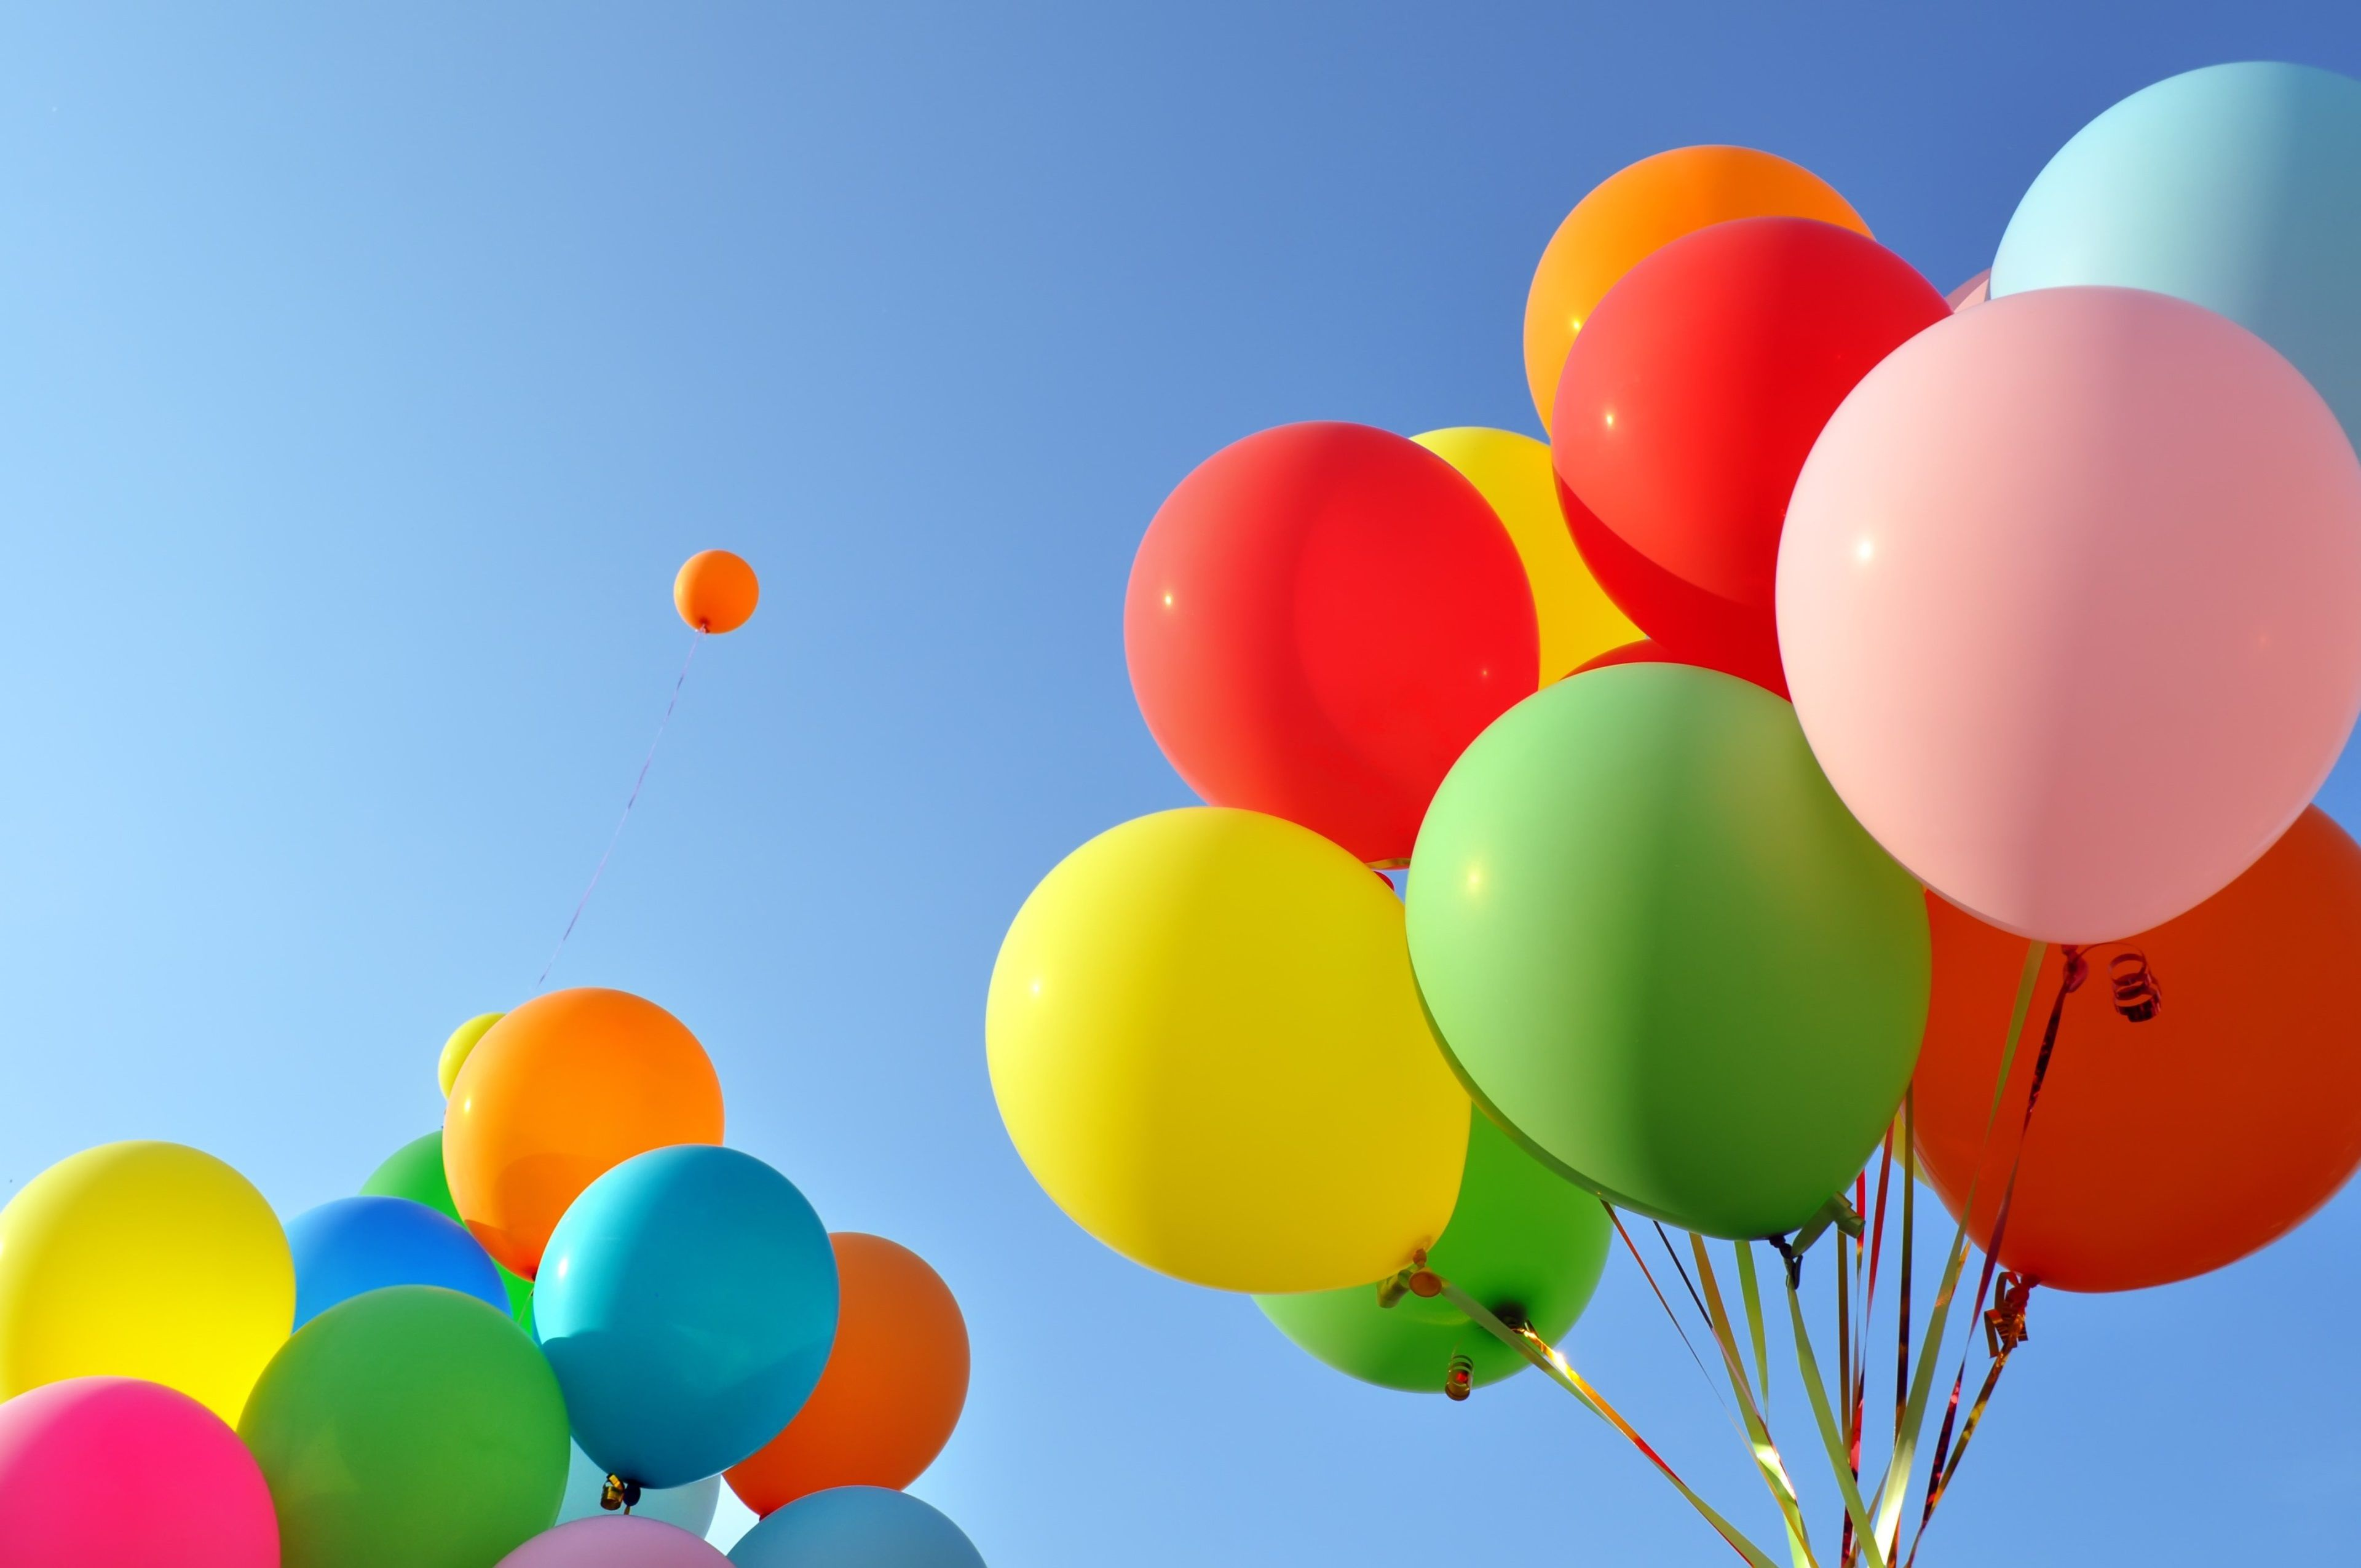

